In [1]:
# %%

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc_params
from cycler import cycler
import seaborn as sns
import time
import json
import os
import fastsim as fsim

sns.set_theme()

SHOW_PLOTS = os.environ.get("SHOW_PLOTS", "true").lower() == "true"     


# `fastsim3` -- load vehicle and cycle, build simulation, and run

In [13]:
# %%

# load 2012 Ford Fusion from file
veh = fsim.Vehicle.from_file(
    str(fsim.package_root() / "../../tests/assets/2012_Ford_Fusion.yaml")
)
veh_no_save = veh.copy()
veh_no_save.save_interval = None

# Set `save_interval` at vehicle level -- cascades to all sub-components with time-varying states
veh.save_interval = 1

# load cycle from file
cyc = fsim.Cycle.from_resource("cycles/udds.csv")

# instantiate `SimDrive` simulation object
sd = fsim.SimDrive(veh, cyc)

# simulation start time
t0 = time.perf_counter()
# run simulation
sd.walk()
# simulation end time
t1 = time.perf_counter()
print(f"fastsim-3 `sd.walk()` elapsed time with `save_interval` of 1:\n{t1-t0:.2e} s")


# instantiate `SimDrive` simulation object
sd_no_save = fsim.SimDrive(veh_no_save, cyc)

# simulation start time
t0 = time.perf_counter()
# run simulation
sd_no_save.walk()
# simulation end time
t1 = time.perf_counter()
print(f"fastsim-3 `sd.walk()` elapsed time with `save_interval` of None:\n{t1-t0:.2e} s")

fastsim-3 `sd.walk()` elapsed time with `save_interval` of 1:
4.11e-04 s
fastsim-3 `sd.walk()` elapsed time with `save_interval` of None:
1.71e-04 s


# `fastsim-2` benchmarking

In [14]:
# %%

sd2 = sd.to_fastsim2()
t0 = time.perf_counter()
sd2.sim_drive()
t1 = time.perf_counter()
print(f"fastsim-2 `sd.walk()` elapsed time: {t1-t0:.2e} s")


fastsim-2 `sd.walk()` elapsed time: 1.62e-03 s


# Visualize results

## Fuel Converter Power

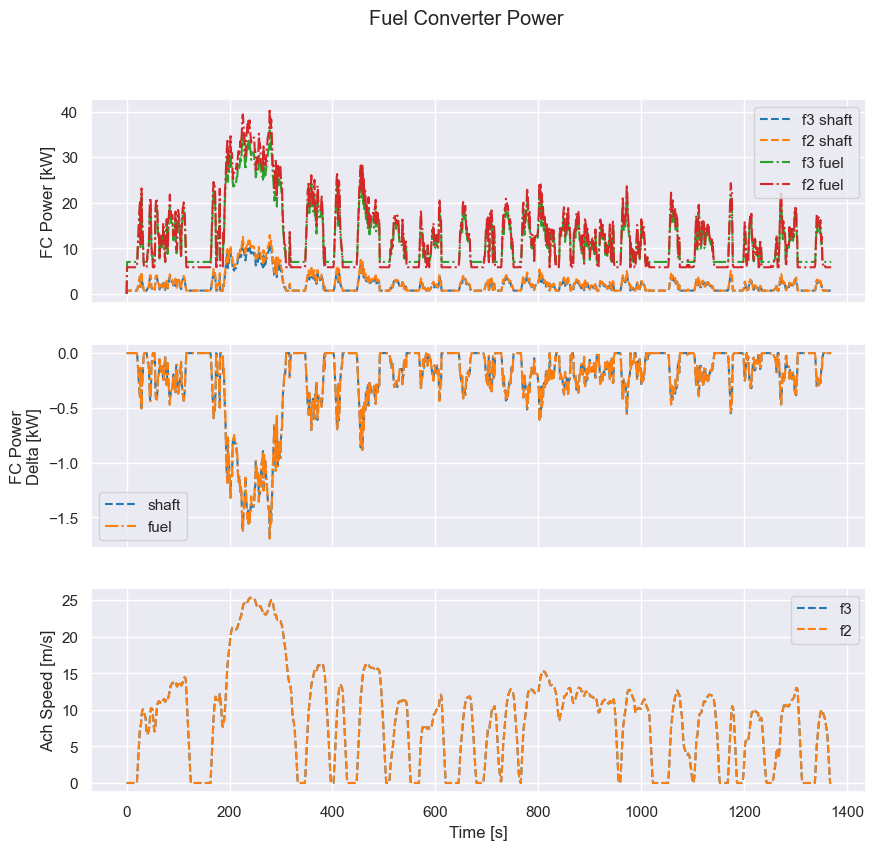

In [13]:
figsize_3_stacked = (10, 9)

# set up cycling of colors and linestyles
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
            '#7f7f7f', '#bcbd22', '#17becf']
baselinestyles = ["--", "-.", ":"]
linestyles = [[c, c] for c in baselinestyles]
linestyles = [x for sublist in linestyles for x in sublist]
default_cycler = (
    cycler(color=colors[:len(linestyles)]) +
    cycler(linestyle=linestyles)
)
plt.rc('axes', prop_cycle=default_cycler)

fig, ax = plt.subplots(3, 1, sharex=True, figsize=figsize_3_stacked)
plt.suptitle("Fuel Converter Power")

ax[0].plot(
    np.array(sd.cyc.time_seconds)[::veh.save_interval],
    (np.array(sd.veh.fc.history.pwr_tractive_watts) +
        np.array(sd.veh.fc.history.pwr_aux_watts)) / 1e3,
    label="f3 shaft",
)
ax[0].plot(
    np.array(sd2.cyc.time_s.tolist())[::veh.save_interval],
    np.array(sd2.fc_kw_out_ach.tolist()),
    label="f2 shaft",
)
ax[0].plot(
    np.array(sd.cyc.time_seconds)[::veh.save_interval],
    np.array(sd.veh.fc.history.pwr_fuel_watts) / 1e3,
    label="f3 fuel",
)
ax[0].plot(
    np.array(sd2.cyc.time_s.tolist())[::veh.save_interval],
    np.array(sd2.fs_kw_out_ach.tolist()),
    label="f2 fuel",
)
ax[0].set_ylabel("FC Power [kW]")
ax[0].legend()

ax[1].plot(
    np.array(sd.cyc.time_seconds)[::veh.save_interval],
    (np.array(sd.veh.fc.history.pwr_tractive_watts) +
        np.array(sd.veh.fc.history.pwr_aux_watts)) / 1e3 - np.array(sd2.fc_kw_out_ach.tolist()),
    label="shaft",
    linestyle=baselinestyles[0]
)
ax[1].plot(
    np.array(sd.cyc.time_seconds)[::veh.save_interval],
    (np.array(sd.veh.fc.history.pwr_tractive_watts) +
        np.array(sd.veh.fc.history.pwr_aux_watts)) / 1e3 - np.array(sd2.fc_kw_out_ach.tolist()),
    label="fuel",
    linestyle=baselinestyles[1]
)
ax[1].set_ylabel("FC Power\nDelta [kW]")
ax[1].legend()

ax[-1].plot(
    np.array(sd.cyc.time_seconds)[::veh.save_interval],
    np.array(sd.veh.history.speed_ach_meters_per_second),
    label="f3",
)
ax[-1].plot(
    np.array(sd2.cyc.time_s.tolist()),
    np.array(sd2.mps_ach.tolist()),
    label="f2",
)
ax[-1].legend()
ax[-1].set_xlabel("Time [s]")
ax[-1].set_ylabel("Ach Speed [m/s]")
plt.show()

## Fuel Converter Energy

We intend to release a backwards equivalent interpolation option to allow for line-on-line comparison.  

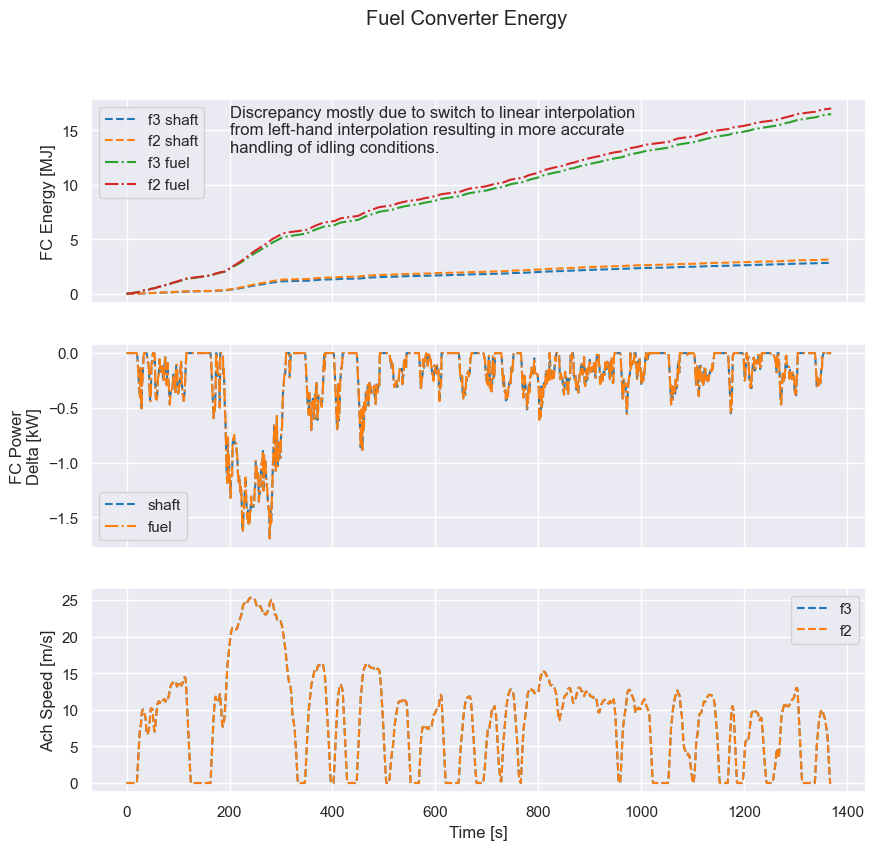

In [14]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=figsize_3_stacked)
plt.suptitle("Fuel Converter Energy")

ax[0].plot(
    np.array(sd.cyc.time_seconds)[::veh.save_interval],
    (np.array(sd.veh.fc.history.energy_tractive_joules) +
        np.array(sd.veh.fc.history.energy_aux_joules)) / 1e6,
    label="f3 shaft",
)
ax[0].plot(
    np.array(sd2.cyc.time_s.tolist())[::veh.save_interval],
    np.array(sd2.fc_cumu_mj_out_ach.tolist()),
    label="f2 shaft",
)
ax[0].plot(
    np.array(sd.cyc.time_seconds)[::veh.save_interval],
    np.array(sd.veh.fc.history.energy_fuel_joules) / 1e6,
    label="f3 fuel",
)
ax[0].plot(
    np.array(sd2.cyc.time_s.tolist())[::veh.save_interval],
    np.array(sd2.fs_cumu_mj_out_ach.tolist()),
    label="f2 fuel",
)
ax[0].text(
    200, 
    13, 
    "Discrepancy mostly due to switch to linear interpolation\n" + 
    "from left-hand interpolation resulting in more accurate\n" + 
    "handling of idling conditions.",
)
ax[0].set_ylabel("FC Energy [MJ]")
ax[0].legend()

ax[1].plot(
    np.array(sd.cyc.time_seconds)[::veh.save_interval],
    (np.array(sd.veh.fc.history.pwr_tractive_watts) +
        np.array(sd.veh.fc.history.pwr_aux_watts)) / 1e3 - np.array(sd2.fc_kw_out_ach.tolist()),
    label="shaft",
    linestyle=baselinestyles[0]
)
ax[1].plot(
    np.array(sd.cyc.time_seconds)[::veh.save_interval],
    (np.array(sd.veh.fc.history.pwr_tractive_watts) +
        np.array(sd.veh.fc.history.pwr_aux_watts)) / 1e3 - np.array(sd2.fc_kw_out_ach.tolist()),
    label="fuel",
    linestyle=baselinestyles[1]
)
ax[1].set_ylabel("FC Power\nDelta [kW]")
ax[1].legend()

ax[-1].plot(
    np.array(sd.cyc.time_seconds)[::veh.save_interval],
    np.array(sd.veh.history.speed_ach_meters_per_second),
    label="f3",
)
ax[-1].plot(
    np.array(sd2.cyc.time_s.tolist()),
    np.array(sd2.mps_ach.tolist()),
    label="f2",
)
ax[-1].legend()
ax[-1].set_xlabel("Time [s]")
ax[-1].set_ylabel("Ach Speed [m/s]")
plt.show()

## Road Loads


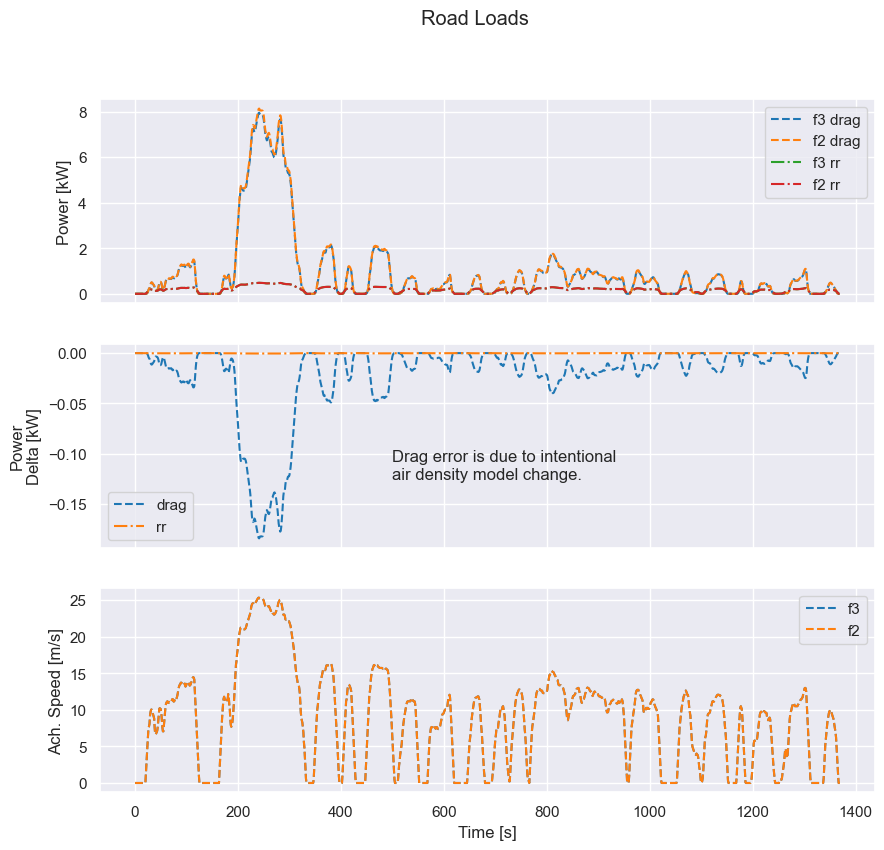

In [15]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=figsize_3_stacked)
plt.suptitle("Road Loads")

ax[0].plot(
    np.array(sd.cyc.time_seconds)[::veh.save_interval],
    np.array(sd.veh.history.pwr_drag_watts) / 1e3,
    label="f3 drag",
)
ax[0].plot(
    np.array(sd2.cyc.time_s.tolist())[::veh.save_interval],
    np.array(sd2.drag_kw.tolist()),
    label="f2 drag",
)
ax[0].plot(
    np.array(sd.cyc.time_seconds)[::veh.save_interval],
    np.array(sd.veh.history.pwr_rr_watts) / 1e3,
    label="f3 rr",
)
ax[0].plot(
    np.array(sd2.cyc.time_s.tolist())[::veh.save_interval],
    np.array(sd2.rr_kw.tolist()),
    label="f2 rr",
)
ax[0].set_ylabel("Power [kW]")
ax[0].legend()

ax[1].plot(
    np.array(sd.cyc.time_seconds)[::veh.save_interval],
    np.array(sd.veh.history.pwr_drag_watts) /
    1e3 - np.array(sd2.drag_kw.tolist()),
    label="drag",
    linestyle=baselinestyles[0],
)
ax[1].plot(
    np.array(sd.cyc.time_seconds)[::veh.save_interval],
    np.array(sd.veh.history.pwr_rr_watts) /
    1e3 - np.array(sd2.rr_kw.tolist()),
    label="rr",
    linestyle=baselinestyles[1],
)
ax[1].text(500, -0.125, "Drag error is due to intentional\nair density model change.")
ax[1].set_ylabel("Power\nDelta [kW]")
ax[1].legend()

ax[-1].plot(
    np.array(sd.cyc.time_seconds)[::veh.save_interval],
    np.array(sd.veh.history.speed_ach_meters_per_second),
    label="f3",
)
ax[-1].plot(
    np.array(sd2.cyc.time_s.tolist()),
    np.array(sd2.mps_ach.tolist()),
    label="f2",
)
ax[-1].legend()
ax[-1].set_xlabel("Time [s]")
ax[-1].set_ylabel("Ach. Speed [m/s]")
plt.show()


# Benchmarking

## CPU Performance
See above for cpu benchmarking.

## Memory Profiling
Within [benchmarks](./../../../benchmarks/), here are the results of running the benchmarking tests.

These benchmarks show that `fastsim-3` uses about 63% less memory than `fastsim-2`, which results in a substantially greater potential to leverage HPC and cloud computing via multiprocessing parallelization, enabling more capacity to use FASTSim for large scale simulations.  

### python -m memory_profiler f2.py

```
Filename: /Users/cbaker2/Documents/GitHub/fastsim-3/benchmarks/./f2.py  
Line #    Mem usage    Increment  Occurrences   Line Contents
=============================================================
10  163.438 MiB  163.438 MiB           1   @profile(precision=3)
11                                         def build_and_run_sim_drive():
12  164.234 MiB    0.797 MiB           2       veh = fsr.RustVehicle.from_file(
13  163.438 MiB    0.000 MiB           1           str(fsim.package_root() / "resources/vehdb/2012_Ford_Fusion.yaml")
14                                             )
15  164.375 MiB    0.141 MiB           1       cyc = fsr.RustCycle.from_resource("cycles/udds.csv")
16  165.453 MiB    1.078 MiB           1       sd = fsr.RustSimDrive(cyc, veh)
17  165.656 MiB    0.203 MiB           1       sd.sim_drive()
```

### python -m memory_profiler f3-save-int-1.py

```
Filename: /Users/cbaker2/Documents/GitHub/fastsim-3/benchmarks/./f3-save-int-1.py
Line #    Mem usage    Increment  Occurrences   Line Contents
=============================================================
    5   61.562 MiB   61.562 MiB           1   @profile(precision=3)
    6                                         def build_and_run_sim_drive():
    7   62.125 MiB    0.562 MiB           2       veh = fsim.Vehicle.from_file(
    8                                                 # TODO: figure out why `str` is needed here
    9   61.562 MiB    0.000 MiB           1           str(fsim.package_root() / "../../tests/assets/2012_Ford_Fusion.yaml")
    10                                             )
    11   62.125 MiB    0.000 MiB           1       veh.save_interval = 1
    12   62.312 MiB    0.188 MiB           1       cyc = fsim.Cycle.from_resource("cycles/udds.csv")
    13   62.406 MiB    0.094 MiB           1       sd = fsim.SimDrive(veh, cyc)
    14   62.953 MiB    0.547 MiB           1       sd.walk()
```

### python -m memory_profiler f3-save-int-none.py

```
Filename: /Users/cbaker2/Documents/GitHub/fastsim-3/benchmarks/./f3-save-int-none.py
Line #    Mem usage    Increment  Occurrences   Line Contents
=============================================================
     5   61.203 MiB   61.203 MiB           1   @profile(precision=3)
     6                                         def build_and_run_sim_drive():
     7   61.766 MiB    0.562 MiB           2       veh = fsim.Vehicle.from_file(
     8                                                 # TODO: figure out why `str` is needed here
     9   61.203 MiB    0.000 MiB           1           str(fsim.package_root() / "../../tests/assets/2012_Ford_Fusion.yaml")
    10                                             )
    11   61.766 MiB    0.000 MiB           1       veh.save_interval = None
    12   61.938 MiB    0.172 MiB           1       cyc = fsim.Cycle.from_resource("cycles/udds.csv")
    13   62.031 MiB    0.094 MiB           1       sd = fsim.SimDrive(veh, cyc)
    14   62.031 MiB    0.000 MiB           1       sd.walk()
```